<a href="https://colab.research.google.com/github/Sea370/DL_school/blob/master/Resnet_of_simpsons_Kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)


In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:

!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


5.3.0


In [ ]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/My\ Drive/simpsons/simpsons4.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Jan  7 12:53:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

![alt text](https://)В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
# фиксируем случайные последовательности
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # АУГУМЕНТАЦИЯ ДЛЯ ТЕСТОВОГО НАБОРА:
        transform_train = transforms.Compose([
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomRotation(25),
                transforms.RandomHorizontalFlip()                      
            ])
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        if self.mode == 'train':
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = transform_train(x)
            x = np.array(np.array(x) / 255, dtype='float32')
            x = transform(x)
        else:
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = np.array(np.array(x) / 255, dtype='float32')
            x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        # для последующих аугументаций нужно вернуть картинку
        return image

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

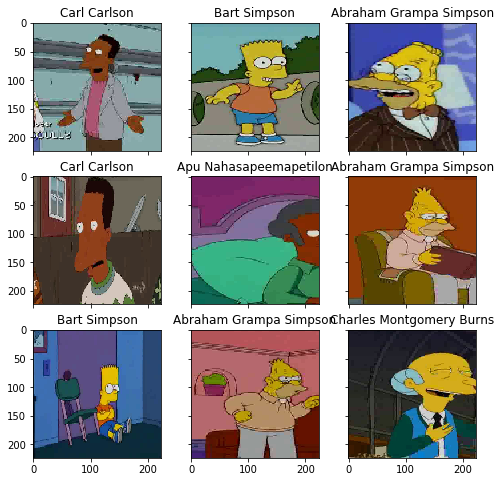

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети




In [ ]:
# будем файнтюнить Resnet18
# импортируем предварительно обученную модель

from torchvision import models

model_ResNet = models.resnet18(pretrained=True, progress=True)

# посмотрим на неё
model_ResNet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# определяем кол-во классов
n_classes = len(np.unique(train_val_labels))

In [ ]:
# меняем последний слой - классификатор исходя из кол-ва классов
model_ResNet.fc = nn.Linear(512, n_classes)

# отправляем модель на видеокарту
model_ResNet.to(DEVICE)

# кол-во параметров модели
sum([p.numel() for p in model_ResNet.parameters() if p.requires_grad])

11198058

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        # выбираем оптимизатор adam и learning rate меньше стандартной
        # поскольку используется предварительно обученная модель
        # добавляем небольшую L2 регуляризацию
        # на последних (30%) эпохах ещё дополнительно снижаем learning rate
        # используем scheduler к-рый уменьшает текущий learning rate в 4 раза,
        # если val_loss не снижается в течении 2-х эпох

        opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.25, patience=2)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(int(0.7*epochs)):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            scheduler.step(val_loss)

            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
        opt = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.25, patience=2)

        for epoch in range(int(0.7*epochs), epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

            scheduler.step(val_loss)

            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
      

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# определяем с какой моделью работаем
model_name = model_ResNet



In [ ]:
# запускаем обучение модели на 10-ти эпохах
history = train(train_dataset, val_dataset, model=model_name, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.0526476577061954


epoch:  10%|█         | 1/10 [03:21<30:10, 201.13s/it]


Epoch 001 train_loss: 1.0526     val_loss 0.3731 train_acc 0.7649 val_acc 0.9178
loss 0.4189345995864182


epoch:  20%|██        | 2/10 [06:42<26:48, 201.06s/it]


Epoch 002 train_loss: 0.4189     val_loss 0.2966 train_acc 0.8910 val_acc 0.9192
loss 0.24294280538103963


epoch:  30%|███       | 3/10 [10:03<23:28, 201.14s/it]


Epoch 003 train_loss: 0.2429     val_loss 0.2366 train_acc 0.9366 val_acc 0.9400
loss 0.18646943465153332


epoch:  40%|████      | 4/10 [13:25<20:08, 201.39s/it]


Epoch 004 train_loss: 0.1865     val_loss 0.1836 train_acc 0.9502 val_acc 0.9536
loss 0.15026778997004475


epoch:  50%|█████     | 5/10 [16:46<16:46, 201.27s/it]


Epoch 005 train_loss: 0.1503     val_loss 0.2027 train_acc 0.9592 val_acc 0.9496
loss 0.13308220437003349


epoch:  60%|██████    | 6/10 [20:07<13:25, 201.32s/it]


Epoch 006 train_loss: 0.1331     val_loss 0.1607 train_acc 0.9631 val_acc 0.9587
loss 0.10514523213938912


epoch:  70%|███████   | 7/10 [23:29<10:04, 201.37s/it]


Epoch 007 train_loss: 0.1051     val_loss 0.1700 train_acc 0.9715 val_acc 0.9585
loss 0.04294529056156492


epoch:  80%|████████  | 8/10 [26:50<06:42, 201.48s/it]


Epoch 008 train_loss: 0.0429     val_loss 0.1351 train_acc 0.9895 val_acc 0.9725
loss 0.031834740677203134


epoch:  90%|█████████ | 9/10 [30:12<03:21, 201.55s/it]


Epoch 009 train_loss: 0.0318     val_loss 0.1361 train_acc 0.9918 val_acc 0.9721
loss 0.024344320319984725


epoch: 100%|██████████| 10/10 [33:33<00:00, 201.38s/it]


Epoch 010 train_loss: 0.0243     val_loss 0.1304 train_acc 0.9941 val_acc 0.9755


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

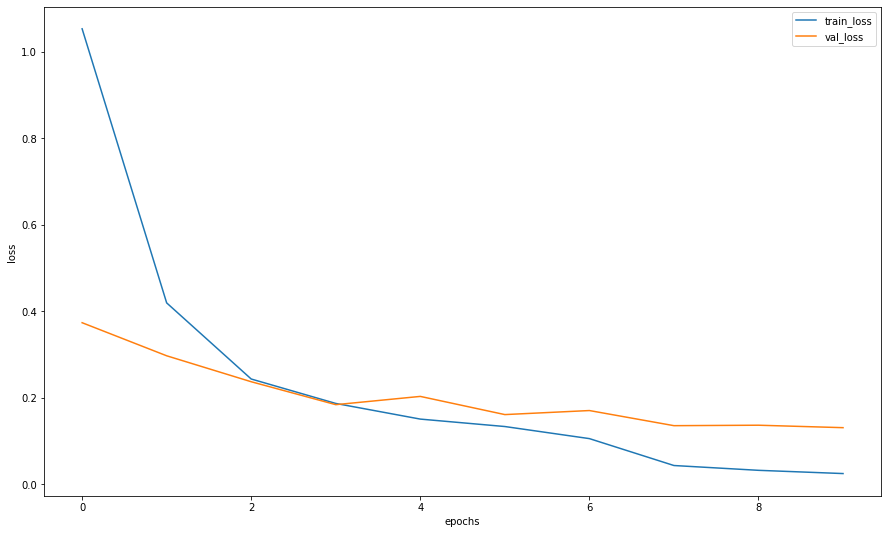

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_name, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_name, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
# посмотрим на реальные и предсказанные метки

print(actual_labels)
print(label_encoder.inverse_transform(actual_labels))

[6, 2, 6, 0, 0, 0, 4, 0, 4, 2, 2, 4, 0, 5, 4, 6, 2, 6, 4, 6]
['charles_montgomery_burns' 'apu_nahasapeemapetilon'
 'charles_montgomery_burns' 'abraham_grampa_simpson'
 'abraham_grampa_simpson' 'abraham_grampa_simpson' 'bart_simpson'
 'abraham_grampa_simpson' 'bart_simpson' 'apu_nahasapeemapetilon'
 'apu_nahasapeemapetilon' 'bart_simpson' 'abraham_grampa_simpson'
 'carl_carlson' 'bart_simpson' 'charles_montgomery_burns'
 'apu_nahasapeemapetilon' 'charles_montgomery_burns' 'bart_simpson'
 'charles_montgomery_burns']


In [ ]:
print(preds_class)

['charles_montgomery_burns', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon', 'bart_simpson', 'abraham_grampa_simpson', 'carl_carlson', 'bart_simpson', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'bart_simpson', 'charles_montgomery_burns']


In [ ]:
label_encoder.transform(preds_class)


array([6, 2, 6, 0, 0, 0, 4, 0, 4, 2, 2, 4, 0, 5, 4, 6, 2, 6, 4, 6])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
# Произведём оценку "f1 скора"

from sklearn.metrics import f1_score

f1_score(actual_labels, label_encoder.transform(preds_class), average="micro")


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.


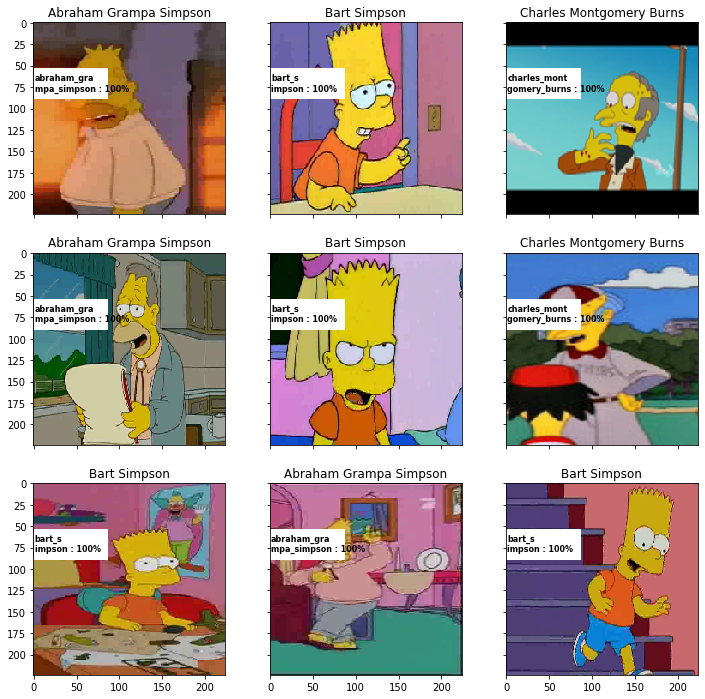

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_name, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_name, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# сохраняем файл на google drive и затем отправляем его на kaggle
my_submit.to_csv('gdrive/My Drive/simpsons/simple_cnn_baseline.csv', index=False)